# CS450.4 Final Project - adhavle - Classifying Partisan Bias in News Articles
- I am attempting to replicate some of the methods used in [Classifying Partisan Bias in News Articles:
 Leveraging an Understanding of Political Language
 and Article Structure](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1234/final-reports/final-report-169502805.pdf), which uses a dataset from a competition on detecting hyperpartisan and fake news.
- Dataset location [Data for PAN at SemEval 2019 Task 4: Hyperpartisan News Detection](https://zenodo.org/records/1489920)
- Also see [Hyperpartisan News Detection 2019](https://pan.webis.de/semeval19/semeval19-web/#data) and [SemEval-2019 Task 4: Hyperpartisan News Detection](https://aclanthology.org/S19-2145.pdf)


In [3]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#### Comments
 - The dataset is downloaded to, and prepared in, the `dataset` dir
 - `articles-validation-bypublisher-20181122-html-escaped.xml` contains a list of 150,000 news articles (sourced online)
 - `ground-truth-validation-bypublisher-20181122.xml` contains the targets for these articles
 - Targets are `left`, `left-center`, `least`, `right-center`, `right`

In [6]:
dataset_dir = os.path.join(os.getcwd(), "dataset")
training_data_file = os.path.join(dataset_dir, "articles-validation-bypublisher-20181122-html-escaped.xml")
target_data_file = os.path.join(dataset_dir, "ground-truth-validation-bypublisher-20181122.xml")

In [33]:
datadf = pd.read_xml(path_or_buffer = training_data_file)
targetdf = pd.read_xml(path_or_buffer = target_data_file)
df = pd.concat([datadf, targetdf], axis = 1)
df.columns = [
    'id',
    'published-at',
    'title',
    'article',
    'id2',
    'hyperpartisan',
    'bias',
    'url',
    'labeled-by'
]

#### Comments
- Training data and targets are now in a single dataframe.
- There should be 150,000 articles
- The `id` field from training and target sets should match
- No record should have an empty `article` or `bias` field

In [34]:
# run some test cases to ensure the data is good
if len(df) == 150_000:
    print(f"PASS: dataframe has {len(df)} records as expected")
else:
    print(f"FAIL: dataframe has {len(df)} records - expected 150,000")

def validate_column_does_not_have_null_values(column_name):
    if df[column_name].isnull().sum() == 0:
        print(f"PASS: no null values detected for column '{column_name}'")
    else:
        print(f"FAIL: {df[column_name].isnull().sum()} null values for column '{column_name}' not expected")

validate_column_does_not_have_null_values("id")
validate_column_does_not_have_null_values("id2")
validate_column_does_not_have_null_values("article")
validate_column_does_not_have_null_values("bias")

id_matches = df['id'] == df['id2']
n_not_matched = id_matches.value_counts().get(False, 0)
n_matched = id_matches.value_counts().get(True, 0)
if n_matched == 150_000 and n_not_matched == 0:
    print(f"PASS: all article IDs from training file and target file matched (id == id2 for all records)")
else:
    print(f"FAIL: {n_matched} article IDs from training file matched, BUT {n_not_matched} article IDs did not match")

PASS: dataframe has 150000 records as expected
PASS: no null values detected for column 'id'
PASS: no null values detected for column 'id2'
PASS: no null values detected for column 'article'
PASS: no null values detected for column 'bias'
PASS: all article IDs from training file and target file matched (id == id2 for all records)


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             150000 non-null  int64 
 1   published-at   100492 non-null  object
 2   title          137723 non-null  object
 3   article        150000 non-null  object
 4   id2            150000 non-null  int64 
 5   hyperpartisan  150000 non-null  bool  
 6   bias           150000 non-null  object
 7   url            150000 non-null  object
 8   labeled-by     150000 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 9.3+ MB


In [36]:
df.head()

,id,published-at,title,article,id2,hyperpartisan,bias,url,labeled-by
0,17,2004-07-29,SAN FRANCISCO / Head of Juvenile Probation Dep...,"<p>Chief juvenile probation officer <a href=""/...",17,False,left-center,http://sfgate.com/politics/article/SAN-FRANCIS...,publisher
1,23,2017-04-20,"University leaders ban pro-life flag display, ...",<p>Pro-life students at Wilfrid Laurier Univer...,23,True,right,https://thecollegefix.com/post/32204/,publisher
2,29,2017-09-12,"DONALD TRUMP, GET YOUR TINY PIGGY PERVERT HAND...",<p>Time for Hillary Clinton to go back to Beng...,29,True,left,https://wonkette.com/622815/donald-trump-get-y...,publisher
3,32,2016-06-05,DIRTY: Hillary Clinton Implies Trump is a Nazi...,<p></p> \n<p>Do you want to know why violent u...,32,True,right,http://thegatewaypundit.com/2016/06/dirty-croo...,publisher
4,37,2015-01-12,A Bipartisan Work Plan,<p>American workers continue to struggle with ...,37,False,right-center,https://cfr.org/report/bipartisan-work-plan,publisher


In [37]:
hy_df = df.groupby(['hyperpartisan', 'bias'])['bias'].count()
h, b, c = [], [], []
for k,v in hy_df.items():
    h.append(k[0])
    b.append(k[1])
    c.append(v)

pd.options.display.max_rows = len(h)
display(pd.DataFrame({"hyperpartisan": h, "bias": b, "count": c}))

,hyperpartisan,bias,count
0,False,least,38296
1,False,left-center,23473
2,False,right-center,13231
3,True,left,37500
4,True,right,37500


### Comments
 - As expected, the hyperpartisan label corresponds to categories `left` and `right`
 - I will focus on predicting `bias` and ignore the `hyperpartisan` column since it can be inferred from `bias`
 - The `id` and `id2` fields have served their purpose in validating the join and can be dropped
 - Additionally dropping fields `published-at`, `title`, `url`, and `labeled-by` that won't be used in this analysis (while noting that `title` could contain useful information)
 - Lastly, the `bias` field will be mapped to numerical values

In [38]:
df = df.drop(['id', 'id2', 'hyperpartisan', 'published-at', 'title', 'url', 'labeled-by'], axis=1)

bias_mapping = {'left': 0, 'left-center': 1, 'least': 2, 'right-center': 3, 'right': 4 }
bias_mapping_reverse = dict((v,k) for k,v in bias_mapping.items())
df['bias'] = df['bias'].map(bias_mapping)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   article  150000 non-null  object
 1   bias     150000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


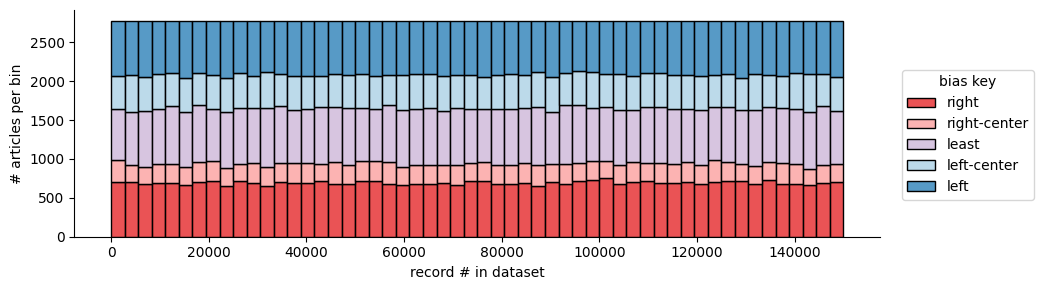

In [93]:
base_palette = sns.color_palette("Paired")
bias_palette = [
    base_palette[1], # blue (left)
    base_palette[0], # light blue (left-center)
    base_palette[8], # purple (least)
    base_palette[4], # light red (right-center)
    base_palette[5], # red (right)
]

data_distribution_chart = sns.displot(
    data = df,
    x = df.index,
    hue = "bias",
    multiple = "stack",
    height = 3,
    aspect = 3,
    hue_order = list(bias_mapping.values()),
    palette = bias_palette,
    legend = False
    # faced_kws = { "legend_data": bias_mapping_reverse }
)

data_distribution_chart.set_xlabels("record # in dataset")
data_distribution_chart.set_ylabels("# articles per bin")

ax = data_distribution_chart.axes[0, 0]
keys = list(bias_mapping.keys())
keys.reverse()
ax.legend(
    labels = keys,
    title = "bias key",
    loc = "center right",
    bbox_to_anchor=(0.7, 0.2, 0.5, 0.5)
)
plt.show()

#### Comments
 - The 5 categories are distributed roughly evenly across the dataset
 - The top (blue) and bottom (red) regions represent the hyperpartisan articles
 - Middle bands (light blue, light red, purple) are not considered hyperpartisan

#### Determining the feature size for training
 - The articles must be vectorized for model training. The plan is to use TF-IDF
 - Optimum values for max_features (and other params) can be found using GridSearchCV, with Logistic Regression
 - I'll assume the optimum choice for Logistic Regression is good enough for other classifiers, and use that option going forward
 - Will use scikit's default stopwords list, even though it has [known issues](https://aclanthology.org/W18-2502/)
 - GridSearchCV was crashing the kernel - working around that by doing the same thing manually

In [94]:
cv_max_features = [1000, 2500]
cv_ngram_upper_range = [1, 2]

# fetch cartesian product of feature values, for grid search
from itertools import product
cv_params = list(product(cv_max_features, cv_ngram_upper_range))

cv_result = []
for max_features, ngram_upper_range in cv_params:

    vectorizer = TfidfVectorizer(
        lowercase=False,
        stop_words='english', 
        max_features=max_features,
        min_df=5,
        max_df=0.7,
        ngram_range=(1,ngram_upper_range))

    vec_time = time.time()
    bag_of_words = vectorizer.fit_transform(df['article'])
    vec_time = time.time() - vec_time
    print(f"vec_time {vec_time:.3f}")

    bag_of_words_df = pd.DataFrame(
        bag_of_words.toarray(), 
        columns=vectorizer.get_feature_names_out())
    x_train, x_test, y_train, y_test = train_test_split(bag_of_words_df, 
                                                    df['bias'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df['bias'])

    logregmodel = LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')
    model_time = time.time()
    logregmodel.fit(x_train, y_train)
    model_time = time.time() - model_time
    model_score = logregmodel.score(x_test, y_test)

    cv_result.append([model_score, max_features, ngram_upper_range, vec_time, model_time])
    print(f"model_time {model_time:.3f}")
    print(f"model_score {model_score:.3f}")

cv_df = pd.DataFrame(
    cv_result,
    columns = ['model_score', 'max_features', 'ngram_upper_range', 'vectorizer_time', 'train_time'])
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_rows = len(cv_result)
display(cv_df)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/adhavle/ml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2503/183998778.py", line 20, in <module>
    bag_of_words = vectorizer.fit_transform(df['article'])
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/adhavle/ml/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/adhavle/ml/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/adhavle/ml/lib/python3.12/site-packages/sklearn/feature_extraction/text.py", line 1376, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                  

#### Comments
- Best performance is with `5000` features, and ngram range `(1,2)`
- Previous testing showed `lbfgs` solver vs. `sag` does not have a tangible impact on accuracy. Proceeding with `lbfgs` due to the significantly lower training time.
- Previous testing showed min_df, max_df values did not have much impact or enable reducing feature size. Tuning that has been eliminated from the grid search to scope the search.

Next step: create a TfidVectorizer with 5000 features and (1,2) ngrams (single words and bigrams) and save to disk for quick retreival and later use.

In [ ]:
vectorizer = TfidfVectorizer(
    lowercase=False,
    stop_words='english', 
    max_features=5000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1,2))

bag_of_words = vectorizer.fit_transform(df['article'])
bag_of_words_df = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names_out())

In [21]:
print(bag_of_words_df.info())
bag_of_words_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Columns: 5000 entries, 00 to zone
dtypes: float64(5000)
memory usage: 5.6 GB
None


,00,00 00,00 PDT,000,000 people,01,02,03,04,04 00,...,yes,yesterday,young,young people,younger,youth,youtube,youtube com,zero,zone
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [23]:
dataset_dir = os.path.join(os.getcwd(), "dataset")
bow_pickle_file = os.path.join(dataset_dir, "articles_tfidf_vectorized.pkl")
bag_of_words_df.to_pickle(bow_pickle_file)

# going forward the vectorized df can be loaded using:
# bag_of_words_df = pd.read_pickle(os.path.join(os.getcwd(), "dataset", "articles_tfidf_vectorized.pkl"))

### Classification Using XGBoost

In [20]:
bag_of_words_df = pd.read_pickle(os.path.join(os.getcwd(), "dataset", "articles_tfidf_vectorized.pkl"))

In [23]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words_df,
                                                df['bias'],
                                                test_size=0.2,
                                                random_state=42,
                                                stratify=df['bias'])

xgb_clf = XGBClassifier(
    num_class=len(bias_mapping),
    eval_metric='mlogloss',
    learning_rate=0.3, # try 0.2, 0.3, 0.4
    n_estimators=100,  # try 50, 100, 200
    random_state=42
)

xgb_clf.fit(x_train, y_train)
xgb_clf.score(x_test, y_test)

/home/adhavle/ml/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:15:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


0.8473

In [24]:
from sklearn.model_selection import GridSearchCV

cv_grid = GridSearchCV(XGBClassifier(num_class=5, eval_metric='mlogloss', random_state=42),
                       param_grid = {
                           'learning_rate' : [0.2, 0.3, 0.4],
                           'n_estimators' : [50, 100, 200],
                       })
cv_grid.fit(x_train, y_train)
cv_grid.best_params_

KeyboardInterrupt: 

In [25]:
cv_grid

,estimator,"XGBClassifier..._class=5, ...)"
,param_grid,"{'learning_rate': [0.2, 0.3, ...], 'n_estimators': [50, 100, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [26]:
cv_grid.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'